In [ ]:
import tensorflow as tf
from keras import __version__ as keras_version

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras_version)

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from nltk import word_tokenize
from functools import lru_cache
import re
import unicodedata
import sys
from collections import Counter
import nltk
nltk.download('brown')
from nltk.corpus import brown
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## First part: The Complex Word Identification Model:

In [ ]:

Dataset = namedtuple('Dataset', 'name, train, test')
Model = namedtuple('Model', 'type, name, dimension, corpus, model')

Get the dataset to train the CWI model


In [ ]:
!wget https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/complex-word-identification-dataset/cwishareddataset.zip

--2024-01-06 22:51:37--  https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/complex-word-identification-dataset/cwishareddataset.zip
Resolving www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)... 134.100.36.5
Connecting to www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)|134.100.36.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cwishareddataset.zip’

cwishareddataset.zi     [ <=>                ]   1.03M  --.-KB/s    in 0.1s    

2024-01-06 22:51:37 (7.07 MB/s) - ‘cwishareddataset.zip’ saved [1075894]


In [ ]:
!unzip cwishareddataset.zip

Archive:  /content/cwishareddataset.zip
   creating: traindevset/
   creating: traindevset/german/
  inflating: traindevset/german/German_Train.tsv  
  inflating: traindevset/german/German_Dev.tsv  
  inflating: traindevset/README.md   
   creating: traindevset/english/
  inflating: traindevset/english/WikiNews_Train.tsv  
  inflating: traindevset/english/Wikipedia_Train.tsv  
  inflating: traindevset/english/Wikipedia_Dev.tsv  
  inflating: traindevset/english/News_Dev.tsv  
  inflating: traindevset/english/News_Train.tsv  
  inflating: traindevset/english/WikiNews_Dev.tsv  
   creating: traindevset/spanish/
  inflating: traindevset/spanish/Spanish_Train.tsv  
  inflating: traindevset/spanish/Spanish_Dev.tsv  
  inflating: README.md               
   creating: testset/
   creating: testset/german/
  inflating: testset/german/German_Test.tsv  
  inflating: testset/README.md       
   creating: testset/english/
  inflating: testset/english/Wikipedia_Test.tsv  
   creating: __MACOSX/
   

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "traindevset/german/"
genres = ['German']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target",
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('German', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

In [ ]:
datasets

[Dataset(name='German', train=                                  id  \
 0     3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG   
 1     3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG   
 2     3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG   
 3     3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG   
 4     3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG   
 ...                              ...   
 6146  3CZH926SICFIJSD3QQZQ6U7J2XHE4S   
 6147  3CZH926SICFIJSD3QQZQ6U7J2XHE4S   
 6148  3CZH926SICFIJSD3QQZQ6U7J2XHE4S   
 6149  3CZH926SICFIJSD3QQZQ6U7J2XHE4S   
 6150  3CZH926SICFIJSD3QQZQ6U7J2XHE4S   
 
                                                                                                                                                                                                      sentence  \
 0                                                                                                                                                          Nürnberg / Frankfurt am Main ( Deutschland ) , 23.   
 1                                                       

Get the glove embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-01-06 22:52:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-06 22:52:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-06 22:52:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove.6B.zip -d embeddings

Archive:  /content/glove.6B.zip
  inflating: embeddings/glove.6B.50d.txt  
  inflating: embeddings/glove.6B.100d.txt  
  inflating: embeddings/glove.6B.200d.txt  
  inflating: embeddings/glove.6B.300d.txt  


Load the embedding model

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'embeddings/'


glove_models = []

glove_defs = [ Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]

for model in glove_defs:
    glove_file = MAIN_PATH + model.name
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))

print(glove_models)

<ipython-input-17-0a27a5859e3f>:15: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, tmp_file)


load model : glove.6B.300d.txt
[Model(type='glove', name='glove.6B.300d.txt', dimension=300, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.KeyedVectors object at 0x7e619d483010>)]


In [ ]:
'''from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'embeddings/'


glove_models = []

glove_defs = [ Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]

for model in glove_defs:
    glove_file = MAIN_PATH + model.name
    output_file = glove_file + '.word2vec'
    glove2word2vec(glove_file, output_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
'''

Process the Dataset in order to formated it:

In [ ]:
dataframe = datasets[0].train[0:30]

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def extract_ngrams_group(group):
    targets = zip(group['target'].values.tolist(), group['start'].values.tolist(),
                 group['end'].values.tolist(), group['binary'].values.tolist())
    for word, start, end, binary in targets:
        tokens = word.split()
        if len(tokens)>1:
            olap_words = [(w, b) for w, s, e, b in targets if overlaps(start, end, s, e)]


grouped = dataframe.groupby('sentence').apply(lambda group : extract_ngrams_group(group))

In [ ]:
wordlist_lowercased = set(i.lower() for i in brown.words())
print (len(wordlist_lowercased))

49815


In [ ]:
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

def build_vocabulary(sentences, embedding_model, dimension):
    all_words = [tpl[0] for sentence in sentences for tpl in sentence['seq']] + list(wordlist_lowercased)
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    vocab_size = len(counter) + 1
    print('# Vocab : {}'.format(vocab_size))
    print('# embeding model  : {}'.format(len(embedding_model.key_to_index)))
    word2index = {word : index for index, (word, count) in enumerate(counter.most_common(), 1)}
    index2word = {index : word for word, index in word2index.items()}
    # +1 required for pad token
    embedding_matrix = np.zeros(((vocab_size), dimension))
    missing_embed_words = []
    i_ = 0
    for word, index in word2index.items():
        if word in embedding_model.key_to_index:
            embedding = embedding_model[word]
        else:
             i_ +=1
             continue
        embedding_matrix[index] = embedding
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    print("i: ", i_ )
    return word2index, index2word, embedding_matrix

def forward_transformation(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    grouped = dataframe.groupby('sentence').apply(lambda row :
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0],
                         'tags': [tag for tag in zip(row['target'],
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentences = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob)
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append({'sent_id' : sent_id, 'sentence' : sentence, 'seq' : sent_repr})
    return sentences

def split_sentence_seqs(sentences):
    words, start_end, binary, prob = [], [], [] ,[]
    for sent in sentences:
        sequence = sent['seq']
        curr_w, curr_se, curr_b, curr_p = map(list, zip(*[(vals[0],
            (vals[1], vals[2]), vals[3], vals[4]) for vals in sequence]))
        words.append(curr_w)
        start_end.append(curr_se)
        binary.append(curr_b)
        prob.append(curr_p)
    return words, start_end, binary, prob

In [ ]:
datasets.append(Dataset('train_all_test_wiki',
        datasets[0].train, datasets[0].test))

In [ ]:
# Append train and test set
dataset_sel = datasets[1]
train_num_rows = dataset_sel.train.shape[0]
train_num_sents = len(list(set(dataset_sel.train.sentence.values.tolist())))

test_num_rows = dataset_sel.test.shape[0]
test_num_sents = len(list(set(dataset_sel.test.sentence.values.tolist())))

dataset = dataset_sel.train.append(dataset_sel.test)
dataset['sent_id'] = dataset.groupby('sentence').ngroup()
dataset_num_rows = dataset.shape[0]
dataset_num_sents = len(list(set(dataset.sentence.values.tolist())))

print('# Rows train : {}'.format(train_num_rows))
print('# Rows test : {}'.format(test_num_rows))
print('# Rows dataset : {}'.format(dataset_num_rows))

print('# Sents train : {}'.format(train_num_sents))
print('# Sents test : {}'.format(test_num_sents))
print('# Sents dataset : {}'.format(dataset_num_sents))

# Rows train : 6151
# Rows test : 795
# Rows dataset : 6946
# Sents train : 687
# Sents test : 96
# Sents dataset : 783


<ipython-input-22-2923e58d7e8c>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset_sel.train.append(dataset_sel.test)


Finally the Dataset to train the model:

In [ ]:
dataset

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob,sent_id
0,3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG,"Nürnberg / Frankfurt am Main ( Deutschland ) , 23.",0,8,Nürnberg,3,9,0,1,1,0.083,623
1,3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG,"Nürnberg / Frankfurt am Main ( Deutschland ) , 23.",11,28,Frankfurt am Main,3,9,0,1,1,0.083,623
2,3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG,"Nürnberg / Frankfurt am Main ( Deutschland ) , 23.",11,20,Frankfurt,3,9,0,0,0,0.000,623
3,3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG,"Nürnberg / Frankfurt am Main ( Deutschland ) , 23.",31,42,Deutschland,3,9,0,1,1,0.083,623
4,3B9XR6P1WEWAF7K4J6K4BOQHHXUBJG,"Nürnberg / Frankfurt am Main ( Deutschland ) , 23.",24,28,Main,3,9,0,0,0,0.000,623
...,...,...,...,...,...,...,...,...,...,...,...,...
790,39O0SQZVJN84BJ0REUHX8DQC8OXR72,Auch hätten sich zuvor schon kleinere Brände ohne Opfer in der Discothek ereignet .,29,37,kleinere,4,8,0,0,0,0.000,102
791,39O0SQZVJN84BJ0REUHX8DQC8OXR72,Auch hätten sich zuvor schon kleinere Brände ohne Opfer in der Discothek ereignet .,38,44,Brände,4,8,0,0,0,0.000,102
792,39O0SQZVJN84BJ0REUHX8DQC8OXR72,Auch hätten sich zuvor schon kleinere Brände ohne Opfer in der Discothek ereignet .,50,55,Opfer,4,8,0,0,0,0.000,102
793,39O0SQZVJN84BJ0REUHX8DQC8OXR72,Auch hätten sich zuvor schon kleinere Brände ohne Opfer in der Discothek ereignet .,63,72,Discothek,4,8,0,0,0,0.000,102


In [ ]:
sentences = forward_transformation(dataset)
train_sentences = sentences[:train_num_sents]
test_sentences = sentences[train_num_sents:]

In [ ]:
words, start_end, binary, prob = split_sentence_seqs(sentences)

In [ ]:
print(words ,' = ', prob)

In [ ]:
sentence_lens = [len(sent) for sent in words]

In [ ]:
sentence_lens

The dimensions of the embedding and vectors for the model:

In [ ]:
embedding_model = glove_models[0].model
dimension = embedding_model.vector_size
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)

# Words : 62645
# Vocab : 54123
# embeding model  : 400000
# Words missing embedding : 0
Embedding shape : (54123, 300)
i:  12625


In [ ]:
import pickle

# build vocabulary and get word2index dictionary
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)
# save word2index dictionary to file
with open('word2index.pkl', 'wb') as f:
    pickle.dump(word2index, f)

# Words : 62645
# Vocab : 54123
# embeding model  : 400000
# Words missing embedding : 0
Embedding shape : (54123, 300)
i:  12625


In [ ]:
# save words dictionary to file
with open('words.pkl', 'wb') as f:
    pickle.dump(words, f)

In [ ]:
# save sentences dictionary to file
with open('sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)

## Padding the input sequences and get the binaries labels

In [ ]:
words_with_indices = [[word2index[word] for word in sent] for sent in words]
sent_lens = [len(sentence['seq']) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

words_padded = pad_sequences(maxlen=sent_max_length, sequences=words_with_indices, padding="post", value=0)
binary_padded = pad_sequences(maxlen=sent_max_length, sequences=binary, padding="post", value=0)
prob_padded = pad_sequences(maxlen=sent_max_length, sequences=prob, padding="post", value=0, dtype="float")

binary_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binary_padded]

Max length sentence : 55


# Split the to train and test set


In [ ]:

# (1) Training set
train_words_padded = words_padded[:train_num_sents]
train_binary_padded = binary_padded[:train_num_sents]
train_binary_padded_categorical = binary_padded_categorical[:train_num_sents]
train_prob_padded = prob_padded[:train_num_sents]
train_start_end = start_end[:train_num_sents]

# (2) Test set
test_words_padded = words_padded[train_num_sents:]
test_binary_padded = binary_padded[train_num_sents:]
test_binary_padded_categorical = binary_padded_categorical[train_num_sents:]
test_prob_padded = prob_padded[train_num_sents:]
test_start_end = start_end[train_num_sents:]

print('Training set length : {}'.format(len(train_words_padded)))
print('Test set length : {}'.format(len(test_words_padded)))

Training set length : 687
Test set length : 96


## Create a kera's callback to validate the model on train

In [ ]:
from sklearn.metrics import f1_score
import keras.callbacks
from keras import backend as K
class Metrics(keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.f1_scores = []
        self.validation_data = validation_data

    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        targ = np.array(targ)
        shape = targ.shape
        targ = targ.reshape((shape[0]*shape[1], shape[2]))
        targ = np.argmax(targ, axis = 1)
        predict = predict.reshape((shape[0]*shape[1]), shape[2])
        predict = np.argmax(predict, axis = 1)
        self.f1s=f1_score(targ, predict)
        print("\nF1 Score:")
        print(f1_score(targ, np.ones(shape[0]*shape[1])))
        self.f1_scores.append(self.f1s)
        return

## Create the keras model for the Complex Word Identification task

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras import backend as K
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

vocab_size = embedding.shape[0]
dimension = embedding.shape[1]

np.set_printoptions(threshold=np.inf)

in_seq = Input(shape=(sent_max_length,))
embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
drop = Dropout(0.1)(embed)
lstm = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(drop)
out = TimeDistributed(Dense(2, activation="softmax"))(lstm)

model = Model(in_seq, out)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

metrics = Metrics((test_words_padded, np.array(test_binary_padded_categorical)))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 55)]              0         
                                                                 
 embedding (Embedding)       (None, 55, 300)           16236900  
                                                                 
 dropout (Dropout)           (None, 55, 300)           0         
                                                                 
 bidirectional (Bidirection  (None, 55, 300)           541200    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 55, 2)             602       
 ributed)                                                        
                                                                 
Total params: 16778702 (64.01 MB)
Trainable params: 16778702 

And Train it:

In [ ]:
history = model.fit(train_words_padded, np.array(train_binary_padded_categorical), batch_size=10,
                    epochs=30, validation_data = (test_words_padded, np.array(test_binary_padded_categorical)),
                    verbose=1, callbacks=[metrics])

Epoch 1/5
3/3 [==============================] - 0s 38ms/step

F1 Score:
0.10412926391382406
69/69 [==============================] - 42s 606ms/step - loss: 8.4421e-04 - accuracy: 0.9997 - val_loss: 0.2779 - val_accuracy: 0.9430
Epoch 2/5
3/3 [==============================] - 0s 38ms/step

F1 Score:
0.10412926391382406
69/69 [==============================] - 25s 359ms/step - loss: 6.9185e-04 - accuracy: 0.9998 - val_loss: 0.2851 - val_accuracy: 0.9388
Epoch 3/5
3/3 [==============================] - 0s 36ms/step

F1 Score:
0.10412926391382406
69/69 [==============================] - 24s 353ms/step - loss: 6.8511e-04 - accuracy: 0.9998 - val_loss: 0.2903 - val_accuracy: 0.9439
Epoch 4/5
3/3 [==============================] - 0s 36ms/step

F1 Score:
0.10412926391382406
69/69 [==============================] - 24s 350ms/step - loss: 5.4844e-04 - accuracy: 0.9999 - val_loss: 0.2966 - val_accuracy: 0.9428
Epoch 5/5
3/3 [==============================] - 0s 38ms/step

F1 Score:
0.104129263

Now let´s plot some chart to see the model performance:

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: ignored

The F1 Score

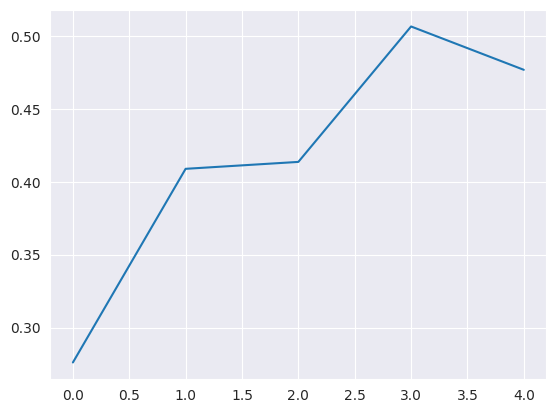

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()

## Optional, if you want to save the trained CWI model into your gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'model_CWI_full.h5'
path_dir = F"/content/gdrive/My Drive/{model_save_name}"

Save the model to google drive

In [ ]:
from keras.models import load_model

model.save(path_dir)  # creates a HDF5 file 'model_CWI_full.h5'

Retrieve the model from google drive (if decide to save it)

In [ ]:
from keras.models import load_model

model_cwi = load_model(path_dir)

## Now, let´s define some useful functions in order to use the CWI with some out of samples sentences

Function for clean the data and remove non characters symbols

In [ ]:
stop_words_ = set(stopwords.words('english'))
def cleaner(word):
  #Remove links
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                '', word, flags=re.MULTILINE)
  word = re.sub('[\W]', ' ', word)
  word = re.sub('[^a-zA-Z]', ' ', word)
  return word.lower().strip()

In [ ]:
import pickle
# load word2index dictionary from file
with open('/content/gdrive/MyDrive/project_nlp_data/words.pkl', 'rb') as f:
    words = pickle.load(f)
# load word2index dictionary from file
with open('/content/gdrive/MyDrive/project_nlp_data/word2index.pkl', 'rb') as f:
    word2index = pickle.load(f)
with open('/content/gdrive/MyDrive/project_nlp_data/sentences.pkl', 'rb') as f:
    sentences = pickle.load(f)

In [ ]:
words_with_indices = [[word2index[word] for word in sent] for sent in words]
sent_lens = [len(sentence['seq']) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))

Max length sentence : 103


Function for to create the padded sequence

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def process_input(input_text):
  input_text = cleaner(input_text)
  clean_text = []
  index_list =[]
  input_token = []
  index_list_zipf = []
  for i, word in enumerate(input_text.split()):
    if word in word2index:
      clean_text.append(word)
      input_token.append(word2index[word])
    else:
      index_list.append(i)
  input_padded = pad_sequences(maxlen=sent_max_length, sequences=[input_token], padding="post", value=0)
  return input_padded, index_list, len(clean_text)


In [ ]:
def complete_missing_word(pred_binary, index_list, len_list):
  list_cwi_predictions = list(pred_binary[0][:len_list])
  for i in index_list:
    list_cwi_predictions.insert(i, 0)
  return list_cwi_predictions


# Second part: The Candidates generation and selection using BERT

First, install the libraries

In [ ]:
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load the BERT  model for masked languge

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

bert_model = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model)
model = BertForMaskedLM.from_pretrained(bert_model)
model.eval()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, 

To compute the **Zipf values**, we use the library **wordfreq**

In [ ]:
!pip install wordfreq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info. Did you mean: 'egg_info'?

During handling of the above exception, another exception occurred:

Traceback (most rec

if we want the Zipf of the word "stop":

In [ ]:
from wordfreq import zipf_frequency
zipf_frequency('stop', 'en')


5.52

and for the word "thwart":

In [ ]:
from wordfreq import zipf_frequency
zipf_frequency('thwart', 'en')

3.06

As you can see the word "stop" is the most common.

## Now the function to get the candidates out of BERT (MLM):

In [ ]:
from wordfreq import zipf_frequency
def get_bert_candidates(input_text, list_cwi_predictions, numb_predictions_displayed = 30):
  list_candidates_bert = []
  for word,pred  in zip(input_text.split(), list_cwi_predictions):
    if (pred and (pos_tag([word])[0][1] in ['NNS', 'NN', 'VBP', 'RB', 'VBG','VBD' ]))  or (zipf_frequency(word, 'en')) <2.95:
      replace_word_mask = input_text.replace(word, '[MASK]')
      text = f'[CLS]{replace_word_mask} [SEP] {input_text} [SEP] '
      tokenized_text = tokenizer.tokenize(text)
      masked_index = [i for i, x in enumerate(tokenized_text) if x == '[MASK]'][0]
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [0]*len(tokenized_text)
      tokens_tensor = torch.tensor([indexed_tokens])
      segments_tensors = torch.tensor([segments_ids])
      # Predict all tokens
      with torch.no_grad():
          outputs = model(tokens_tensor, token_type_ids=segments_tensors)
          predictions = outputs[0][0][masked_index]
      predicted_ids = torch.argsort(predictions, descending=True)[:numb_predictions_displayed]
      predicted_tokens = tokenizer.convert_ids_to_tokens(list(predicted_ids))
      list_candidates_bert.append((word, predicted_tokens))
  return list_candidates_bert

In [ ]:
def get_bert_candidates(input_text,  numb_predictions_displayed = 103):
    list_candidates_bert = []
    for word  in input_text.split():
        if (zipf_frequency(word, 'en')) <3.2:
            replace_word_mask = input_text.replace(word, f'[MASK] {word} [MASK]')
            text = f'[CLS]{replace_word_mask} [SEP]'
            tokenized_text = tokenizer.tokenize(text)
            masked_index = [i for i, x in enumerate(tokenized_text) if x == '[MASK]'][0]
            indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
            segments_ids = [0]*len(tokenized_text)
            tokens_tensor = torch.tensor([indexed_tokens])
            segments_tensors = torch.tensor([segments_ids])
            # Predict all tokens
            with torch.no_grad():
                outputs = model(tokens_tensor, token_type_ids=segments_tensors)
                predictions = outputs[0][0][masked_index]
            predicted_ids = torch.argsort(predictions, descending=True)[:numb_predictions_displayed]
            predicted_tokens = tokenizer.convert_ids_to_tokens(list(predicted_ids))
            list_candidates_bert.append((word, predicted_tokens))
    return list_candidates_bert


# Simplifying new sentences:

Given a list of new sentences with complex words:

In [ ]:
list_texts = [
 'The patient has a fractured clavicle and requires immobilization of the affected area.',
 'The patient has gastroesophageal reflux disease (GERD) and should avoid acidic foods and beverages.',
 'The patient has an acute myocardial infarction (AMI) and requires urgent medical intervention.',
 'The patient has hypertension and needs to take antihypertensive medication to lower their blood pressure.'  ,
 'The patient has a herniated lumbar disc and needs physical therapy to alleviate their back pain.',
 'The patient has a pulmonary embolism and needs anticoagulant medication to prevent blood clots.',
 'The patient has gastroenteritis and needs to stay hydrated and rest to recover.'
]

We apply the simplifier to see how it is performing:

In [ ]:
for input_text in list_texts:
  new_text = input_text
  input_padded, index_list, len_list = process_input(input_text)
  pred_cwi = model_cwi.predict(input_padded)
  pred_cwi_binary = np.argmax(pred_cwi, axis = 2)
  complete_cwi_predictions = complete_missing_word(pred_cwi_binary, index_list, len_list)
  bert_candidates =   get_bert_candidates(input_text, complete_cwi_predictions)
  for word_to_replace, l_candidates in bert_candidates:
    tuples_word_zipf = []
    for w in l_candidates:
      if w.isalpha():
        tuples_word_zipf.append((w, zipf_frequency(w, 'en')))
    tuples_word_zipf = sorted(tuples_word_zipf, key = lambda x: x[1], reverse=True)
    print('word_to_replace : ' , word_to_replace )
    new_text = re.sub(word_to_replace, tuples_word_zipf[0][0], new_text)

  print("Original text: ", input_text )
  print("Simplified text:", new_text, "\n")

1/1 [==============================] - 0s 341ms/step
word_to_replace :  patient
word_to_replace :  clavicle
word_to_replace :  immobilization
Original text:  The patient has a fractured clavicle and requires immobilization of the affected area.
Simplified text: The state has a fractured head and requires support of the affected area. 

1/1 [==============================] - 0s 175ms/step
word_to_replace :  patient
word_to_replace :  gastroesophageal
word_to_replace :  disease
word_to_replace :  (GERD)
word_to_replace :  acidic
word_to_replace :  foods
word_to_replace :  beverages.
Original text:  The patient has gastroesophageal reflux disease (GERD) and should avoid acidic foods and beverages.
Simplified text: The man has great reflux problem (and) and should avoid all things and water 

1/1 [==============================] - 0s 275ms/step
word_to_replace :  patient
word_to_replace :  acute
word_to_replace :  myocardial
word_to_replace :  infarction
word_to_replace :  urgent
word_to_r

**Pretty** **good results**

1/1 [==============================] - 0s 189ms/step
word_to_replace :  patient
word_to_replace :  clavicle
word_to_replace :  immobilization
Original text:  The patient has a fractured clavicle and requires immobilization of the affected area.
Simplified text: The state has a fractured head and requires support of the affected area. 

1/1 [==============================] - 0s 159ms/step
word_to_replace :  gastroesophageal
word_to_replace :  disease
word_to_replace :  (GERD)
word_to_replace :  acidic
Original text:  The patient has gastroesophageal reflux disease (GERD) and should avoid acidic foods and beverages.
Simplified text: The patient has great reflux problem (and) and should avoid all foods and beverages. 

1/1 [==============================] - 0s 353ms/step
word_to_replace :  acute
word_to_replace :  myocardial
word_to_replace :  infarction
word_to_replace :  urgent
word_to_replace :  intervention.
Original text:  The patient has an acute myocardial infarction (AMI) and requ

IndexError: ignored

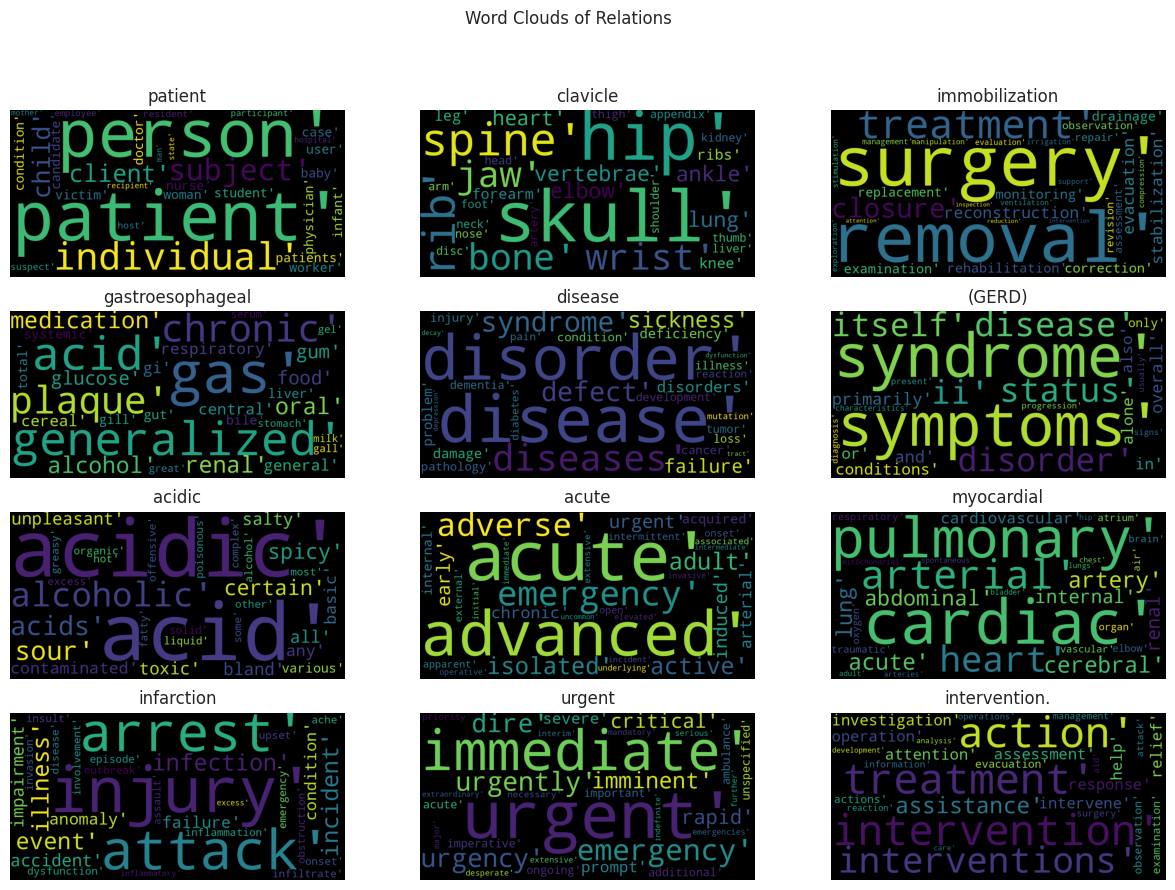

In [ ]:
# Represent list candidates as a word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Relations = {}
for input_text in list_texts:
  new_text = input_text
  input_padded, index_list, len_list = process_input(input_text)
  pred_cwi = model_cwi.predict(input_padded)
  pred_cwi_binary = np.argmax(pred_cwi, axis = 2)
  complete_cwi_predictions = complete_missing_word(pred_cwi_binary, index_list, len_list)
  bert_candidates =   get_bert_candidates(input_text, complete_cwi_predictions)
  list_candidates = []
  for word_to_replace, l_candidates in bert_candidates:
    tuples_word_zipf = []
    for w in l_candidates:
      if w.isalpha():
        tuples_word_zipf.append((w, zipf_frequency(w, 'en')))
    #Extract the list of all high ranked candidates
    high_ranked_candidates = [t[0] for t in tuples_word_zipf if t[1] > 2.95]
    tuples_word_zipf = sorted(tuples_word_zipf, key = lambda x: x[1], reverse=True)
    print('word_to_replace : ' , word_to_replace )
    Relations[word_to_replace] = high_ranked_candidates
    new_text = re.sub(word_to_replace, tuples_word_zipf[0][0], new_text)
    list_candidates.append(tuples_word_zipf[0][0])
  print("Original text: ", input_text )
  print("Simplified text:", new_text, "\n")

# Represent Relations as a word cloud
def word_cloud_relations(Relations):
  #Seperate every key-value pair in the dictionary and represent it as its own word cloud in a grid
    fig, axs = plt.subplots(4, 3, figsize=(15, 10))
    fig.suptitle('Word Clouds of Relations')
    for i, (key, value) in enumerate(Relations.items()):
        wordcloud = WordCloud(width = 1000, height = 500).generate(str(value))
        axs[i//3, i%3].imshow(wordcloud)
        axs[i//3, i%3].set_title(key)
        axs[i//3, i%3].axis("off")
    plt.show()
word_cloud_relations(Relations)
